**All Links related to Assignment 2**

Link to Colab: https://colab.research.google.com/drive/1nNa2-a6KyGURPN7KnpxEYR4o133XBzK2

Link to Github: https://github.com/ServerGCP/ee769-assign2

Link to Streamlit: https://22m0828-ee769-demo.streamlit.app/

Link to Demo: https://drive.google.com/file/d/1aL6to5DxY0DgrTrD9ARB54cTS_sef8mG

# Part 0 - Importing libraries

In [47]:
! pip -q install ucimlrepo shap

from warnings import filterwarnings as fw; fw('ignore') # ignore warnings
from ucimlrepo import fetch_ucirepo # to get dataset directly in python
import matplotlib.pyplot as plt # plotting graphs
import pandas as pd # for dataframes
import numpy as np # for computing
import seaborn as sns # plotting
import pickle # to save models and scaler

seed=69 # set seed

# Part 1 - Regression and out-of-distribution prediction

## 1.a
a. Download the wine quality datasets from https://archive.ics.uci.edu/ml/datasets/Wine+Quality

In [48]:
wine_quality = fetch_ucirepo(id=186) # fetch dataset
df = wine_quality.data.original # dataset
var = wine_quality.variables # features info

df_red = df[df['color']=='red'].drop('color',axis=1).reset_index(drop=True) # seperating red wine
df_white = df[df['color']=='white'].drop('color',axis=1).reset_index(drop=True) # seperating white wine

print(f'Rows: {len(df)} [Red: {len(df_red)} and White: {len(df_white)}]') # Printing lengths
print(var[['name','role','type','missing_values']]) # check info
df.head(5) # peek into df

Rows: 6497 [Red: 1599 and White: 4898]
                    name     role         type missing_values
0          fixed_acidity  Feature   Continuous             no
1       volatile_acidity  Feature   Continuous             no
2            citric_acid  Feature   Continuous             no
3         residual_sugar  Feature   Continuous             no
4              chlorides  Feature   Continuous             no
5    free_sulfur_dioxide  Feature   Continuous             no
6   total_sulfur_dioxide  Feature   Continuous             no
7                density  Feature   Continuous             no
8                     pH  Feature   Continuous             no
9              sulphates  Feature   Continuous             no
10               alcohol  Feature   Continuous             no
11               quality   Target      Integer             no
12                 color    Other  Categorical             no


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


Observation:

*   11 continuous features with no missing entries.
*   Dataset Size: Red - 1599 and White - 4898.




## 1.b
b. Explore, visualize, and pre-process the data as appropriate. [1]

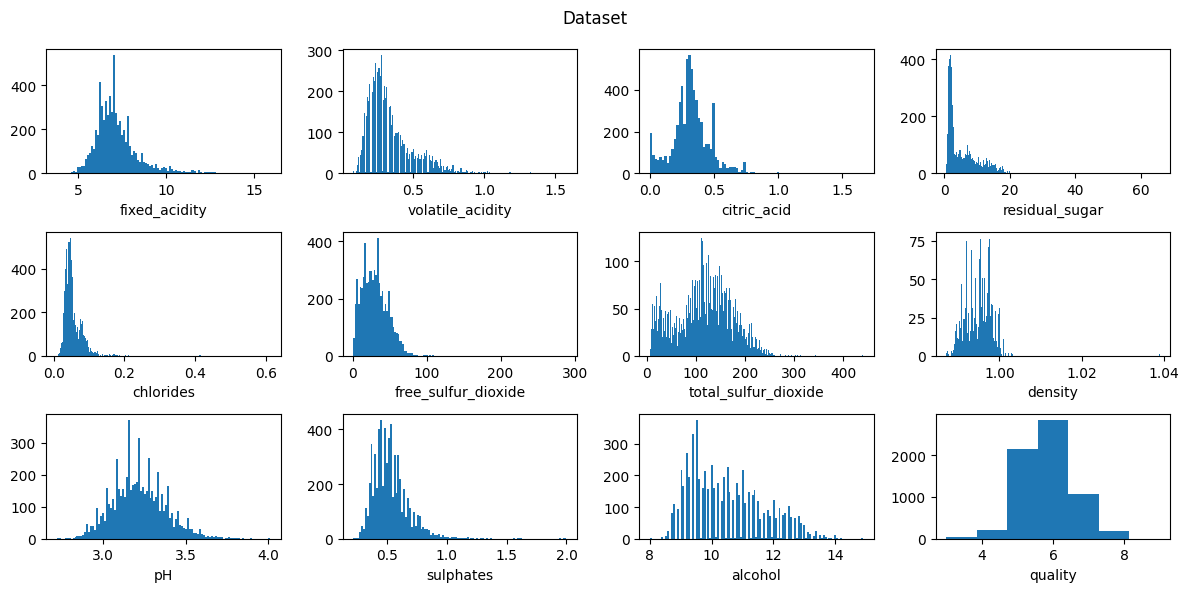

In [49]:
fig, axes = plt.subplots(3, 4, figsize=(12, 6)) # plotting purpose
axes = axes.flatten() # flatten for loop

for i, col in enumerate(df.columns): # over all cols
    if df[col].dtype in ['float64', 'int64']: # if numeric
        axes[i].hist(df[col], bins=len(pd.unique(df[col]))) # get histogram
        axes[i].set_xlabel(col) # set label

fig.suptitle('Dataset') # set title
plt.tight_layout()
plt.show()

Observation:

All variables seem to be spread well. Drop nothing


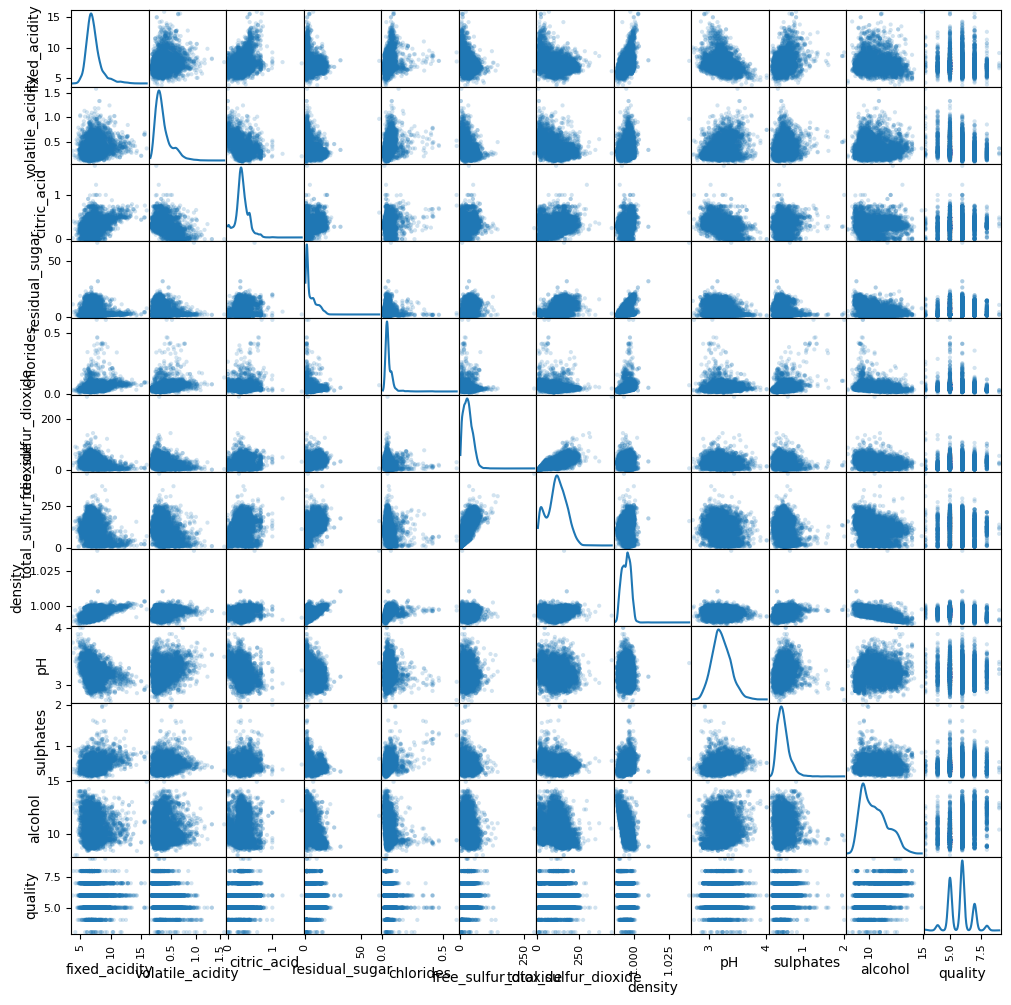

In [50]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde') # kde is kernel density estimation
plt.show()

Obersvations:

1. Variable pairs whose scatter look like straight lines or thin curves are correlated.
2. Variables whose scatter show multiple vertical or horizontal lines are heavily quantized.


Highly correlated features: set()


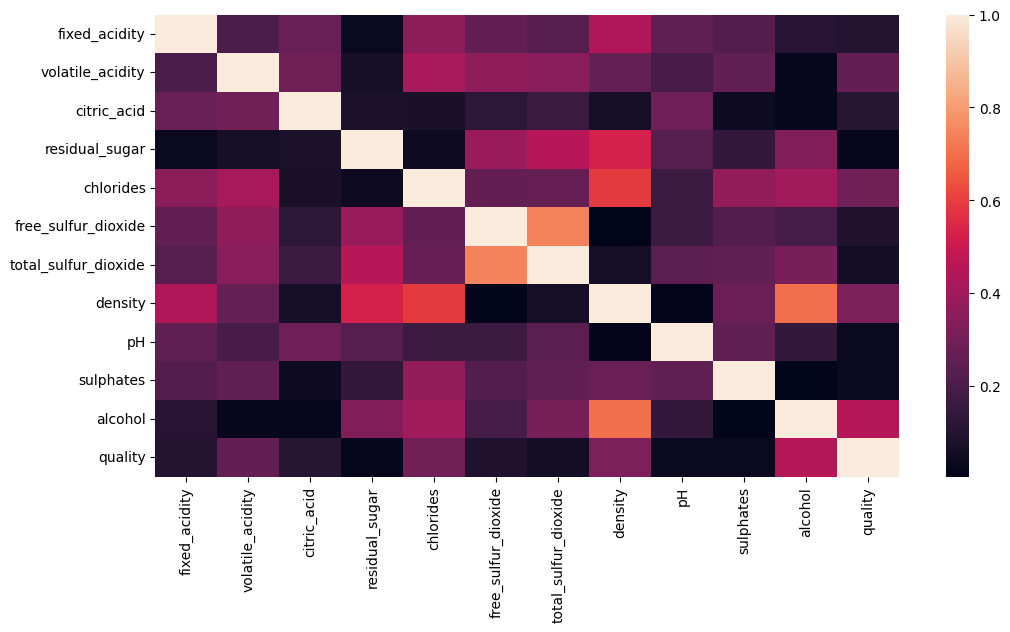

In [51]:
fig, ax = plt.subplots(figsize=(12, 6)) # plotting
corrMatrix = df.corr(method='spearman') # Use spearman for non-linear
sns.heatmap(abs(corrMatrix), annot=False) # Show absolute value

high_corr_vars = set() # to hold record of correlated sets
for i in range(len(corrMatrix.columns)):
    for j in range(i):
        if abs(corrMatrix.iloc[i, j]) > 0.8: # if correlated add to set
            high_corr_vars.add(corrMatrix.columns[i])
            high_corr_vars.add(corrMatrix.columns[j])

print(f'Highly correlated features: {high_corr_vars}')
plt.show()

Obersation: No features are highly correlated i.e more than 0.8

## 1.c
c. Train, validate varying at least one hyperparameter, and test at least two types of models: [2]i. Random forest
ii. Support vector regression with RBF kernel
iii. Neural network with single hidden layer (output layer should have linear activation)

### Red Dataset Processing

1.   Splitting into 80, 10, 10 train valid test
2.   normalizing the dataset with mean 0 std 1

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_red.drop('quality', axis=1) # get features
y = df_red['quality'] # get target

# Split data into temporary dataset and holdout dataset (80% train, 20% holdout)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=seed)

# Split holdout dataset into validation and test datasets (50% validation, 50% test of pending 20%)
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=seed)

# Normalize X_train
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Transform X_val and X_test using the same scaler
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_red_test, y_red_test = X_test, y_test

# Verify the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1279, 11)
Validation set shape: (160, 11)
Test set shape: (160, 11)


In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

# Define models
models = {
    "Random Forest": RandomForestRegressor(),
    "SVR with RBF kernel": SVR(kernel='rbf'),
    "Neural Network": MLPRegressor(max_iter=1000, activation='identity')
}

# Define hyperparameters to varry and search over
params = {
    "Random Forest": {"n_estimators": [50, 100, 200]},
    "SVR with RBF kernel": {"C": [0.1, 1, 10], "gamma": ['scale', 'auto']},
    "Neural Network": {"hidden_layer_sizes": [(50,), (100,), (200,)], "alpha": [0.0001, 0.001, 0.01]}
}

# Train, validate, and test models
for name, model in models.items():
    print(f"Training and tuning {name}...")

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, params[name], cv=5, scoring='neg_mean_squared_error',)
    grid_search.fit(X_train, y_train)

    # Get best estimator
    best_model = grid_search.best_estimator_
    models[name] = best_model

    # Train
    y_train_pred = best_model.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    print(f"Training MSE: {train_mse}")

    # Validate
    y_val_pred = best_model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)
    print(f"Validation MSE: {val_mse}")

    # Test
    y_test_pred = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    print(f"Test MSE: {test_mse}\n")

model_red = models['Random Forest']

Training and tuning Random Forest...
Training MSE: 0.04638817435496481
Validation MSE: 0.34289046875
Test MSE: 0.35113703125000006

Training and tuning SVR with RBF kernel...
Training MSE: 0.2921834435599441
Validation MSE: 0.4334442292580234
Test MSE: 0.41510386249104714

Training and tuning Neural Network...
Training MSE: 0.40534371957915427
Validation MSE: 0.46302021436396446
Test MSE: 0.4903720534661386



Obervation:

We used gridsearch CV to tune the hyperparamters for the best model with least error.

1.   Least testing error is in Random forest model
2.   Most testing error is in Neural Network might be due to the smaller data size, roughy 1500 entries.

#### 1.d
d. Search the net about how to determine the importance of each variable, and find the importance inthe final models tried. Comment on whether the same variables are important for different models.[1]

In [54]:
from sklearn.inspection import permutation_importance
import shap

feature_weights = lambda y: sorted(zip(df_red.columns, y / sum(y)), key=lambda x: x[1], reverse=True) # sorting features based on weights

rf_importances = np.abs(models['Random Forest'].feature_importances_) # using feature_importances_
svr_coefs = np.abs(permutation_importance(models['SVR with RBF kernel'], X_train, y_train, random_state=seed).importances_mean) # using permutation_importance
nn_coefs = np.abs(shap.Explainer(models['Neural Network'].predict, X_train).shap_values(X_train)).mean(axis=0) # using shap

print("Random Forest Feature Importances:")
for i, importance in feature_weights(rf_importances):
    print(f"{i}: {importance}")

print("\nSVR Feature Importances:")
for i, importance in feature_weights(svr_coefs):
    print(f"{i}: {importance}")

print("\nNeural Network Feature Importances:")
for i, importance in feature_weights(nn_coefs):
    print(f"{i}: {importance}")

PermutationExplainer explainer: 1280it [00:15, 30.72it/s]                          

Random Forest Feature Importances:
alcohol: 0.27478554710716785
sulphates: 0.13400956380459736
volatile_acidity: 0.12973488347646053
total_sulfur_dioxide: 0.08851147798777331
chlorides: 0.06921256005011239
density: 0.054275623122812096
pH: 0.054138878639848696
fixed_acidity: 0.052623524523469564
residual_sugar: 0.05037150558763512
citric_acid: 0.04890711615209624
free_sulfur_dioxide: 0.04342931954802693

SVR Feature Importances:
alcohol: 0.2438489037526999
sulphates: 0.15431048299762473
volatile_acidity: 0.14053530165127992
total_sulfur_dioxide: 0.09624966654022467
pH: 0.06686181072448653
citric_acid: 0.06562524562008032
fixed_acidity: 0.06544998320564603
density: 0.05003873511868793
free_sulfur_dioxide: 0.04812935279778343
residual_sugar: 0.03701175825283335
chlorides: 0.031938759338653165

Neural Network Feature Importances:
alcohol: 0.3068081277667752
volatile_acidity: 0.1803703098570047
sulphates: 0.15869285461490862
total_sulfur_dioxide: 0.10269065060251696
pH: 0.06377818242469817

Observations:

1. Consistent Importance of Features:


> *   'Alcohol' consistently appears as an important feature across all models.
> *   'Sulphates', 'volatile acidity', and 'total sulfur dioxide' also consistently rank high in importance across models.


2. Varying Importance Rankings:

> *   While certain features maintain consistent importance levels, their rankings may vary slightly across models.
> *   'Residual sugar' and 'chlorides' show some differences in importance rankings.

3. Inconsistencies in Feature Importance:

> *   Features like 'citric acid', 'density', and 'fixed acidity' exhibit some inconsistencies in importance across models.

4. Model-Specific Importance Patterns:

> *   Each model may emphasize certain features differently based on its algorithm.
For example, the Random Forest model prioritize 'total sulfur dioxide' more than other models.

5. Overall Consistency in Important Features:

> *   Despite some variations, certain features consistently emerge as important predictors of wine quality across different modeling approaches.
This suggests robustness in the importance of features such as 'alcohol', 'sulphates', and 'volatile acidity'.

### White Dataset Processing

1.   Splitting into 80, 10, 10 train valid test
2.   normalizing the dataset with mean 0 std 1

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_white.drop('quality', axis=1) # get features
y = df_white['quality'] # get target

# Split data into temporary dataset and holdout dataset (60% train, 40% holdout)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=seed)

# Split holdout dataset into validation and test datasets (50% validation, 50% test of pending 40%)
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=seed)

# Normalize X_train
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Transform X_val and X_test using the same scaler
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_white_test, y_white_test = X_test, y_test

pickle.dump(scaler, open('white_wine_scaler.pkl', 'wb')) # saving scaler for part 4

# Verify the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (3918, 11)
Validation set shape: (490, 11)
Test set shape: (490, 11)


In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

# Define models
models = {
    "Random Forest": RandomForestRegressor(),
    "SVR with RBF kernel": SVR(kernel='rbf'),
    "Neural Network": MLPRegressor(max_iter=1000, activation='identity')
}

# Define hyperparameters to varry and search over
params = {
    "Random Forest": {"n_estimators": [50, 100, 200]},
    "SVR with RBF kernel": {"C": [0.1, 1, 10], "gamma": ['scale', 'auto']},
    "Neural Network": {"hidden_layer_sizes": [(50,), (100,), (200,)], "alpha": [0.0001, 0.001, 0.01]}
}

# Train, validate, and test models
for name, model in models.items():
    print(f"Training and tuning {name}...")

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, params[name], cv=5, scoring='neg_mean_squared_error',)
    grid_search.fit(X_train, y_train)

    # Get best estimator
    best_model = grid_search.best_estimator_
    models[name] = best_model

    # Train
    y_train_pred = best_model.predict(X_train)
    val_mse = mean_squared_error(y_train, y_train_pred)
    print(f"Training MSE: {val_mse}")

    # Validate
    y_val_pred = best_model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)
    print(f"Validation MSE: {val_mse}")

    # Test
    y_test_pred = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    print(f"Test MSE for: {test_mse}\n")

model_white = models['Random Forest']
pickle.dump(model_white, open('white_wine_model.pkl', 'wb')) # saving model for part 4

Training and tuning Random Forest...
Training MSE: 0.05189612046962736
Validation MSE: 0.3871012244897959
Test MSE for: 0.3326388775510204

Training and tuning SVR with RBF kernel...
Training MSE: 0.3938663528630078
Validation MSE: 0.49265410243751484
Test MSE for: 0.46077535355015087

Training and tuning Neural Network...
Training MSE: 0.5612315136727092
Validation MSE: 0.6086903680573824
Test MSE for: 0.5569870206414753



Obervation:

We used gridsearch CV to tune the hyperparamters for the best model with least error.

1.   Least testing error is in Random forest model
2.   Most testing error is in Neural Network might be due to the smaller data size, roughy 4000 entries.

#### 1.d
d. Search the net about how to determine the importance of each variable, and find the importance inthe final models tried. Comment on whether the same variables are important for different models.[1]

In [57]:
from sklearn.inspection import permutation_importance
import shap

feature_weights = lambda y: sorted(zip(df_white.columns, y / sum(y)), key=lambda x: x[1], reverse=True) # sorting based on importance

rf_importances = np.abs(models['Random Forest'].feature_importances_) # using feature_importances_
svr_coefs = np.abs(permutation_importance(models['SVR with RBF kernel'], X_train, y_train, random_state=seed).importances_mean) # using permutation_importance
nn_coefs = np.abs(shap.Explainer(models['Neural Network'].predict, X_train).shap_values(X_train)).mean(axis=0) # shap explainer

print("Random Forest Feature Importances:")
for i, importance in feature_weights(rf_importances):
    print(f"{i}: {importance}")

print("\nSVR Feature Importances:")
for i, importance in feature_weights(svr_coefs):
    print(f"{i}: {importance}")

print("\nNeural Network Feature Importances:")
for i, importance in feature_weights(nn_coefs):
    print(f"{i}: {importance}")

PermutationExplainer explainer: 3919it [00:28, 85.25it/s]                           


Random Forest Feature Importances:
alcohol: 0.24761527833978703
volatile_acidity: 0.12743660839651666
free_sulfur_dioxide: 0.10802250990809933
residual_sugar: 0.07235891091759393
total_sulfur_dioxide: 0.07064261181844955
pH: 0.06860649183116803
density: 0.06432260220601682
chlorides: 0.06301371334527057
fixed_acidity: 0.06055720770250372
sulphates: 0.05912473592631499
citric_acid: 0.05829932960827951

SVR Feature Importances:
density: 0.21237245270868868
residual_sugar: 0.12006192774162652
alcohol: 0.11596514250508794
volatile_acidity: 0.10401453087422008
pH: 0.0904276656078282
total_sulfur_dioxide: 0.07811837859395661
free_sulfur_dioxide: 0.07102598542731292
citric_acid: 0.061660072004660116
sulphates: 0.05779636586807303
fixed_acidity: 0.04704155900659229
chlorides: 0.041515919661953615

Neural Network Feature Importances:
residual_sugar: 0.2627850109762161
density: 0.24305418287345318
alcohol: 0.18096945853758684
volatile_acidity: 0.1129870772095806
pH: 0.05758313901628077
free_sulf

Observations:

1. Consistent Importance of Features:


> *   'Alcohol' and 'volatile acidity' are consistently important features across all models.


2. Varying Importance Rankings:

> *   'Density' and 'residual sugar' are top features in SVR and Neural Network but not in Random Forest.

3. Model-Specific Insights:

> *   Random Forest gives higher importance to sulfur dioxide features.
> *   Neural Network emphasizes 'density' and 'residual sugar'.

4. Variable Importance Stability:

> *   Despite ranking variations, chemical properties like alcohol content and acidity consistently influence wine quality across models.

5. Overall Consistency in Important Features:

> *   While specific feature rankings differ between models, certain chemical properties remain consistently important predictors of wine quality.

## 1.e
e. Test the model for red with data from white and vice versa, and comment on whether the model forred wines is applicable to white wines and versa or not. [1]

In [58]:
# Test the red wine model with white wine data
y_pred_white = model_red.predict(X_white_test)

# Test the white wine model with red wine data
y_pred_red = model_white.predict(X_red_test)

# Evaluate model performance
red_mse_white = mean_squared_error(y_white_test, y_pred_white)
white_mse_red = mean_squared_error(y_red_test, y_pred_red)

print("MSE when testing red wine model with white wine data:", red_mse_white)
print("MSE when testing white wine model with red wine data:", white_mse_red)

MSE when testing red wine model with white wine data: 0.7706975000000001
MSE when testing white wine model with red wine data: 0.6025017187499999


Observations:

Based on the provided Mean Squared Error (MSE) values:
* MSE for Testing Red Wine Model on Red Wine Data: 0.34
* MSE for Testing White Wine Model on White Wine Data: 0.33
* MSE when Testing Red Wine Model with White Wine Data: 0.77
* MSE when Testing White Wine Model with Red Wine Data: 0.60

Insights:

1. Model Performance on Same Wine Type:

> * The MSE values for testing the red wine model on red wine data and the white wine model on white wine data are relatively low, indicating good performance on their respective wine types.

2. Model Performance Across Wine Types:

> * The MSE values increase significantly when testing the red wine model with white wine data (from 0.34 to 0.77) and when testing the white wine model with red wine data (from 0.33 to 0.60).
These higher MSE values suggest that the models trained on one type of wine data do not generalize well to the other type of wine.

3. Applicability Across Wine Types:

> * Based on the MSE values, it appears that the model trained on red wine data is less applicable to white wine data, and vice versa.
This suggests that there are differences in the relationships between features and wine quality between red and white wines, which the models trained on one type of wine data are not able to capture effectively when applied to the other type.

# Part 2 - Classification

## 2.a
a. Download the data to predict Down syndrome in mice fromhttps://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression#. The prediction problem is toeither predict the genotype (binary) using the gene expression variables from DYRK1A_N to CaNA_N.

In [16]:
# Downloading and extracting the dataset
! rm -rf Data_Cortex_Nuclear.xls
! wget -q https://archive.ics.uci.edu/static/public/342/mice+protein+expression.zip
! unzip -q mice+protein+expression.zip
! rm -rf mice+protein+expression.zip

df = pd.read_excel("Data_Cortex_Nuclear.xls") # readin dataset
df = df.drop(columns=['MouseID','Treatment','Behavior','Genotype']) # dropping irrelvant classes
# df['class'] = df['class'].replace({'Control': 0, 'Ts65Dn': 1})

X = df.drop('class', axis=1)
y = df['class']

print(len(X))
df.head()

1080


,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,class
0,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.122652,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,c-CS-m
1,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.116682,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,c-CS-m
2,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.118508,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,c-CS-m
3,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.132781,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,c-CS-m
4,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.129954,NaN,0.104784,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,c-CS-m


Observations:

1080 sample size and 77 input features

target is 8 class classification

few features have null values

all features are numeric columns

## 2.b
b. Explore, visualize, and pre-process the data as appropriate, including developing a strategy to dealwith missing variables. You can choose to impute the variable. The recommended way is to usemultivariate feature imputation (https://scikit-learn.org/stable/modules/impute.html) [1]

In [17]:
for col in df.columns[:-1]:
  list_vals = pd.unique(df[col]) # get unique values in all features
  print(f'{col}: {df[col].dtypes} type has {len(list_vals)} uniques with {np.sum(pd.isnull(df[col]))} nulls')

DYRK1A_N: float64 type has 1078 uniques with 3 nulls
ITSN1_N: float64 type has 1077 uniques with 3 nulls
BDNF_N: float64 type has 1078 uniques with 3 nulls
NR1_N: float64 type has 1078 uniques with 3 nulls
NR2A_N: float64 type has 1078 uniques with 3 nulls
pAKT_N: float64 type has 1077 uniques with 3 nulls
pBRAF_N: float64 type has 1076 uniques with 3 nulls
pCAMKII_N: float64 type has 1078 uniques with 3 nulls
pCREB_N: float64 type has 1078 uniques with 3 nulls
pELK_N: float64 type has 1078 uniques with 3 nulls
pERK_N: float64 type has 1078 uniques with 3 nulls
pJNK_N: float64 type has 1077 uniques with 3 nulls
PKCA_N: float64 type has 1078 uniques with 3 nulls
pMEK_N: float64 type has 1078 uniques with 3 nulls
pNR1_N: float64 type has 1078 uniques with 3 nulls
pNR2A_N: float64 type has 1078 uniques with 3 nulls
pNR2B_N: float64 type has 1078 uniques with 3 nulls
pPKCAB_N: float64 type has 1078 uniques with 3 nulls
pRSK_N: float64 type has 1078 uniques with 3 nulls
AKT_N: float64 type 

Task is to manage the null values we will use imputer for the same in later part

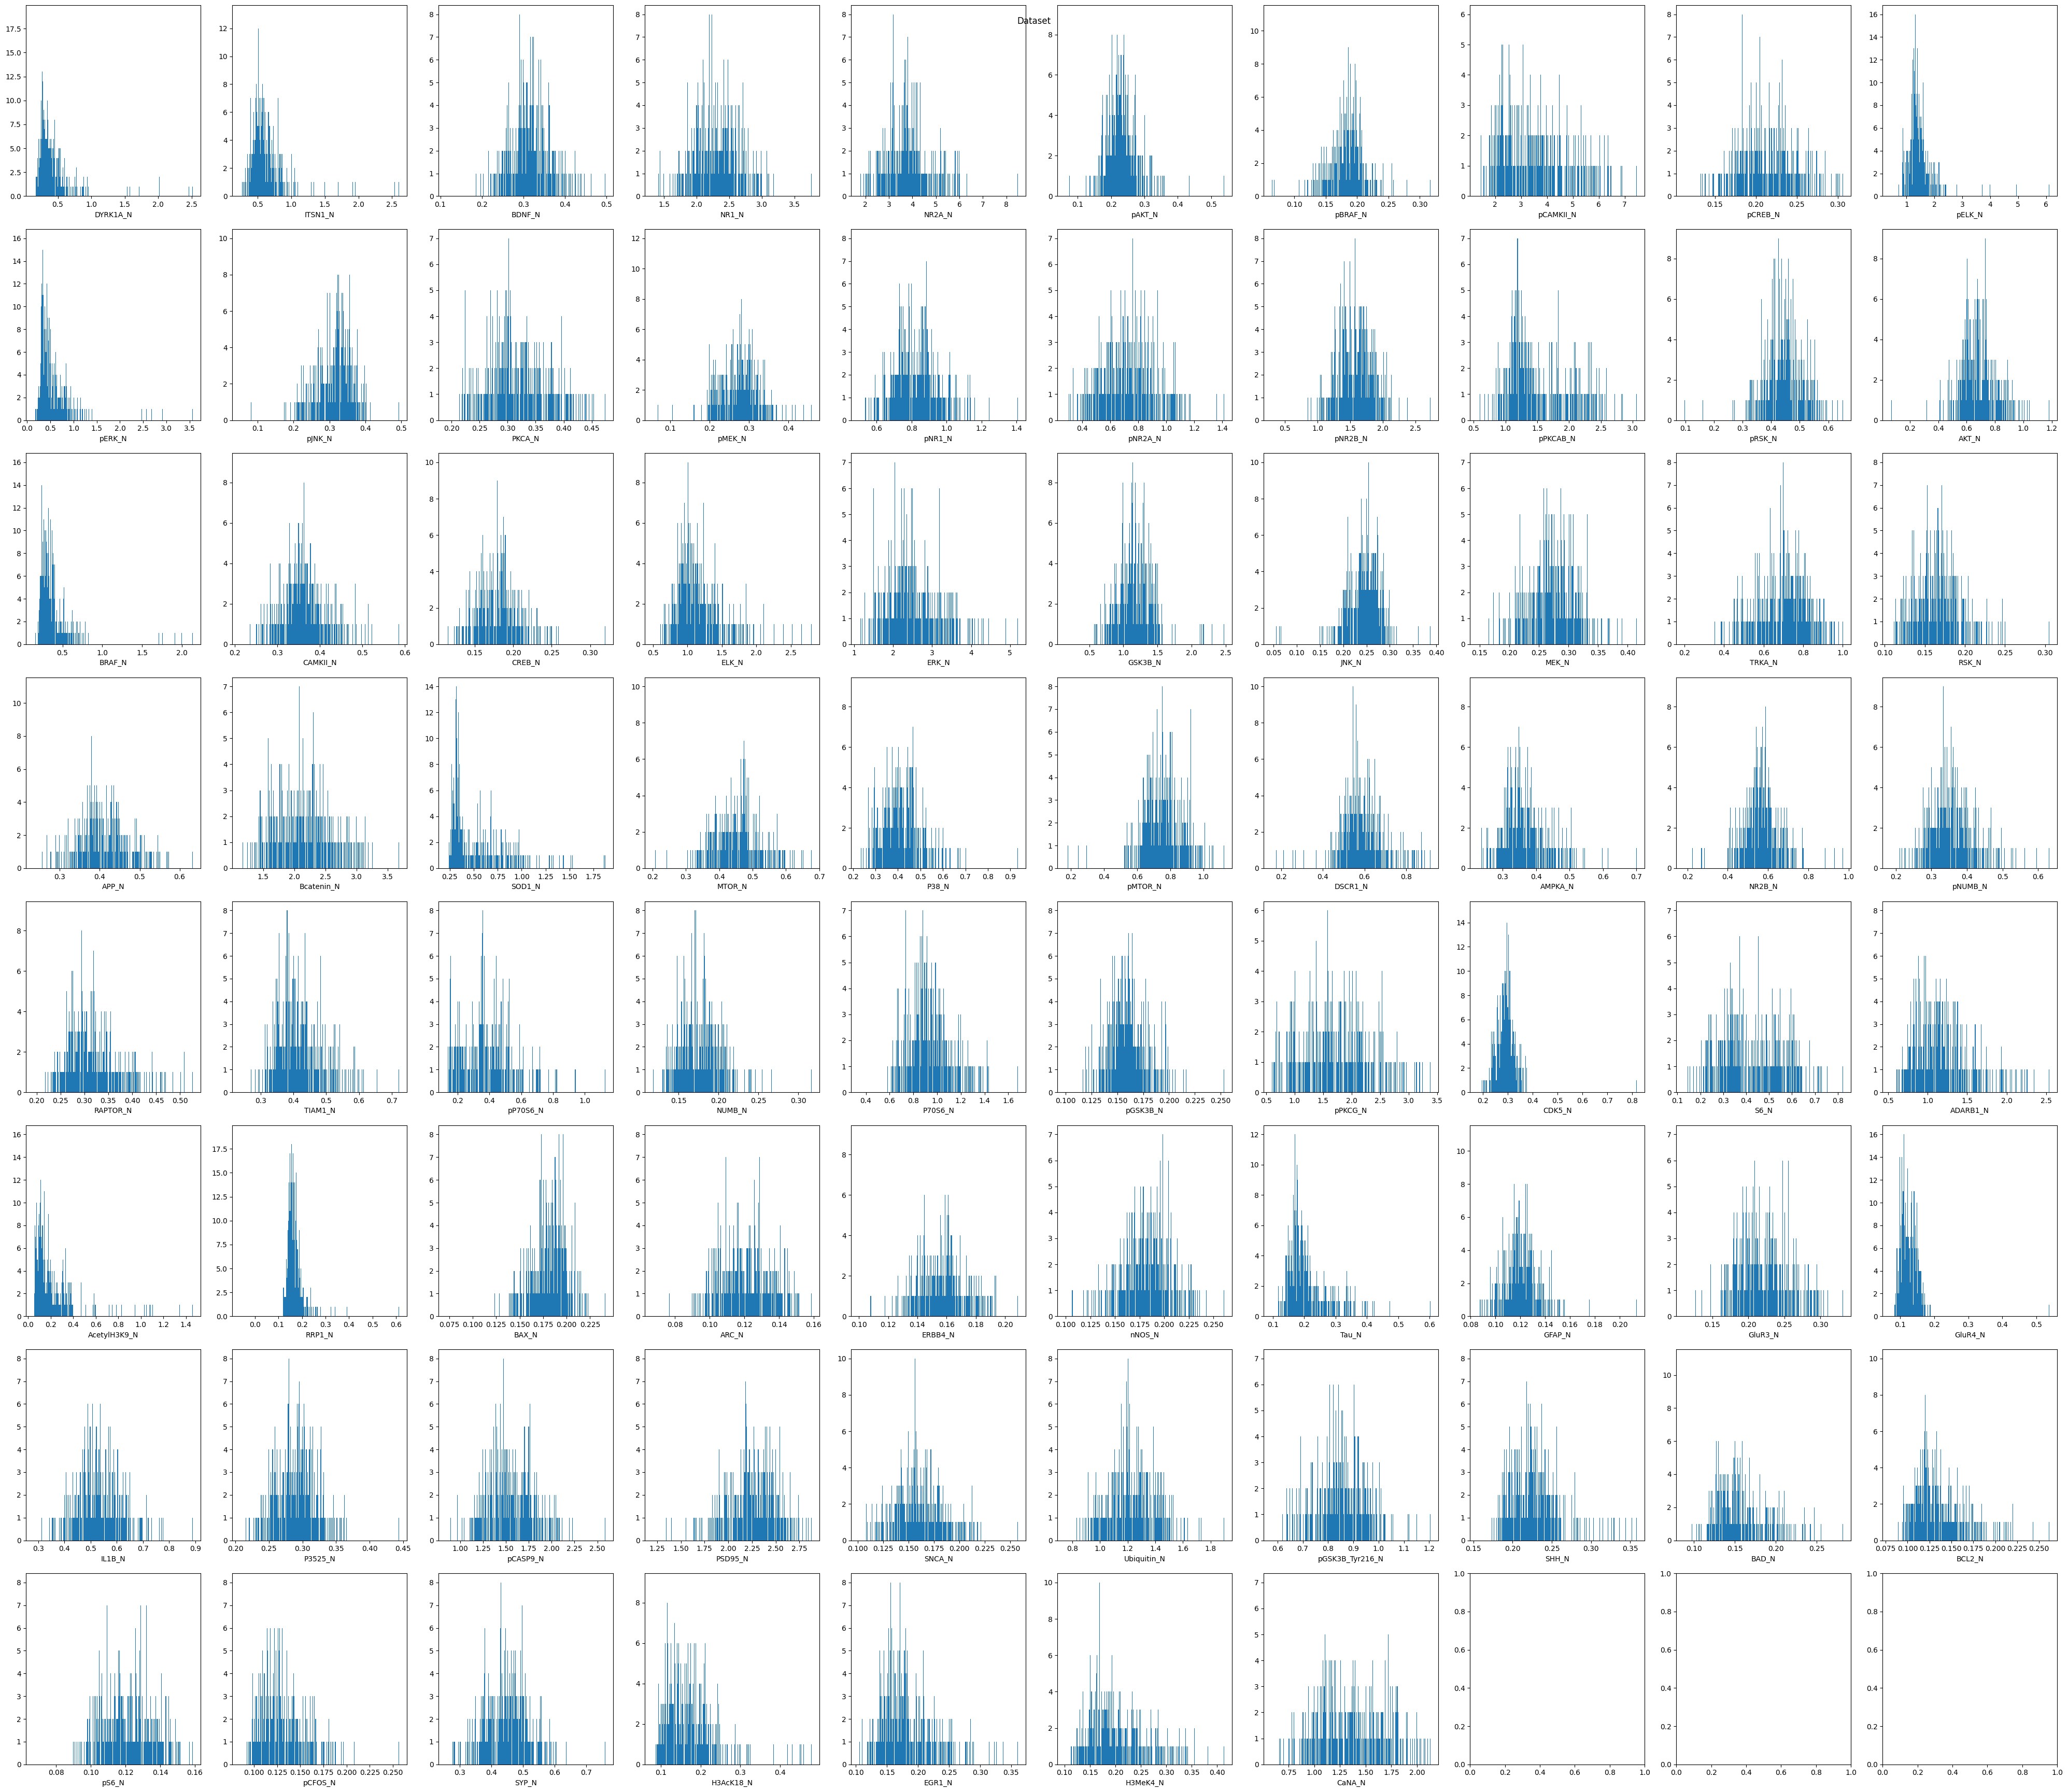

In [18]:
fig, axes = plt.subplots(8, 10, figsize=(40, 35)) # plotting purpose
axes = axes.flatten() # flatten for loop

for i, col in enumerate(df.columns): # over all cols
    if df[col].dtype in ['float64', 'int64']: # if numeric
        axes[i].hist(df[col], bins=len(pd.unique(df[col]))) # get histogram
        axes[i].set_xlabel(col) # set label

fig.suptitle('Dataset') # set title
plt.tight_layout()
plt.show()

Observation:

All variables seem to be spread well. Drop nothing


Highly correlated features: {'ELK_N', 'TRKA_N', 'EGR1_N', 'pS6_N', 'MEK_N', 'pNR2B_N', 'AMPKA_N', 'pMEK_N', 'BCL2_N', 'H3MeK4_N', 'H3AcK18_N', 'Bcatenin_N', 'DYRK1A_N', 'BDNF_N', 'pAKT_N', 'BRAF_N', 'pJNK_N', 'CREB_N', 'JNK_N', 'RSK_N', 'pNR1_N', 'pERK_N', 'ARC_N', 'NR1_N', 'MTOR_N', 'NR2A_N', 'NR2B_N', 'ERK_N', 'pPKCAB_N', 'pBRAF_N', 'PKCA_N', 'ITSN1_N', 'GSK3B_N', 'TIAM1_N'}


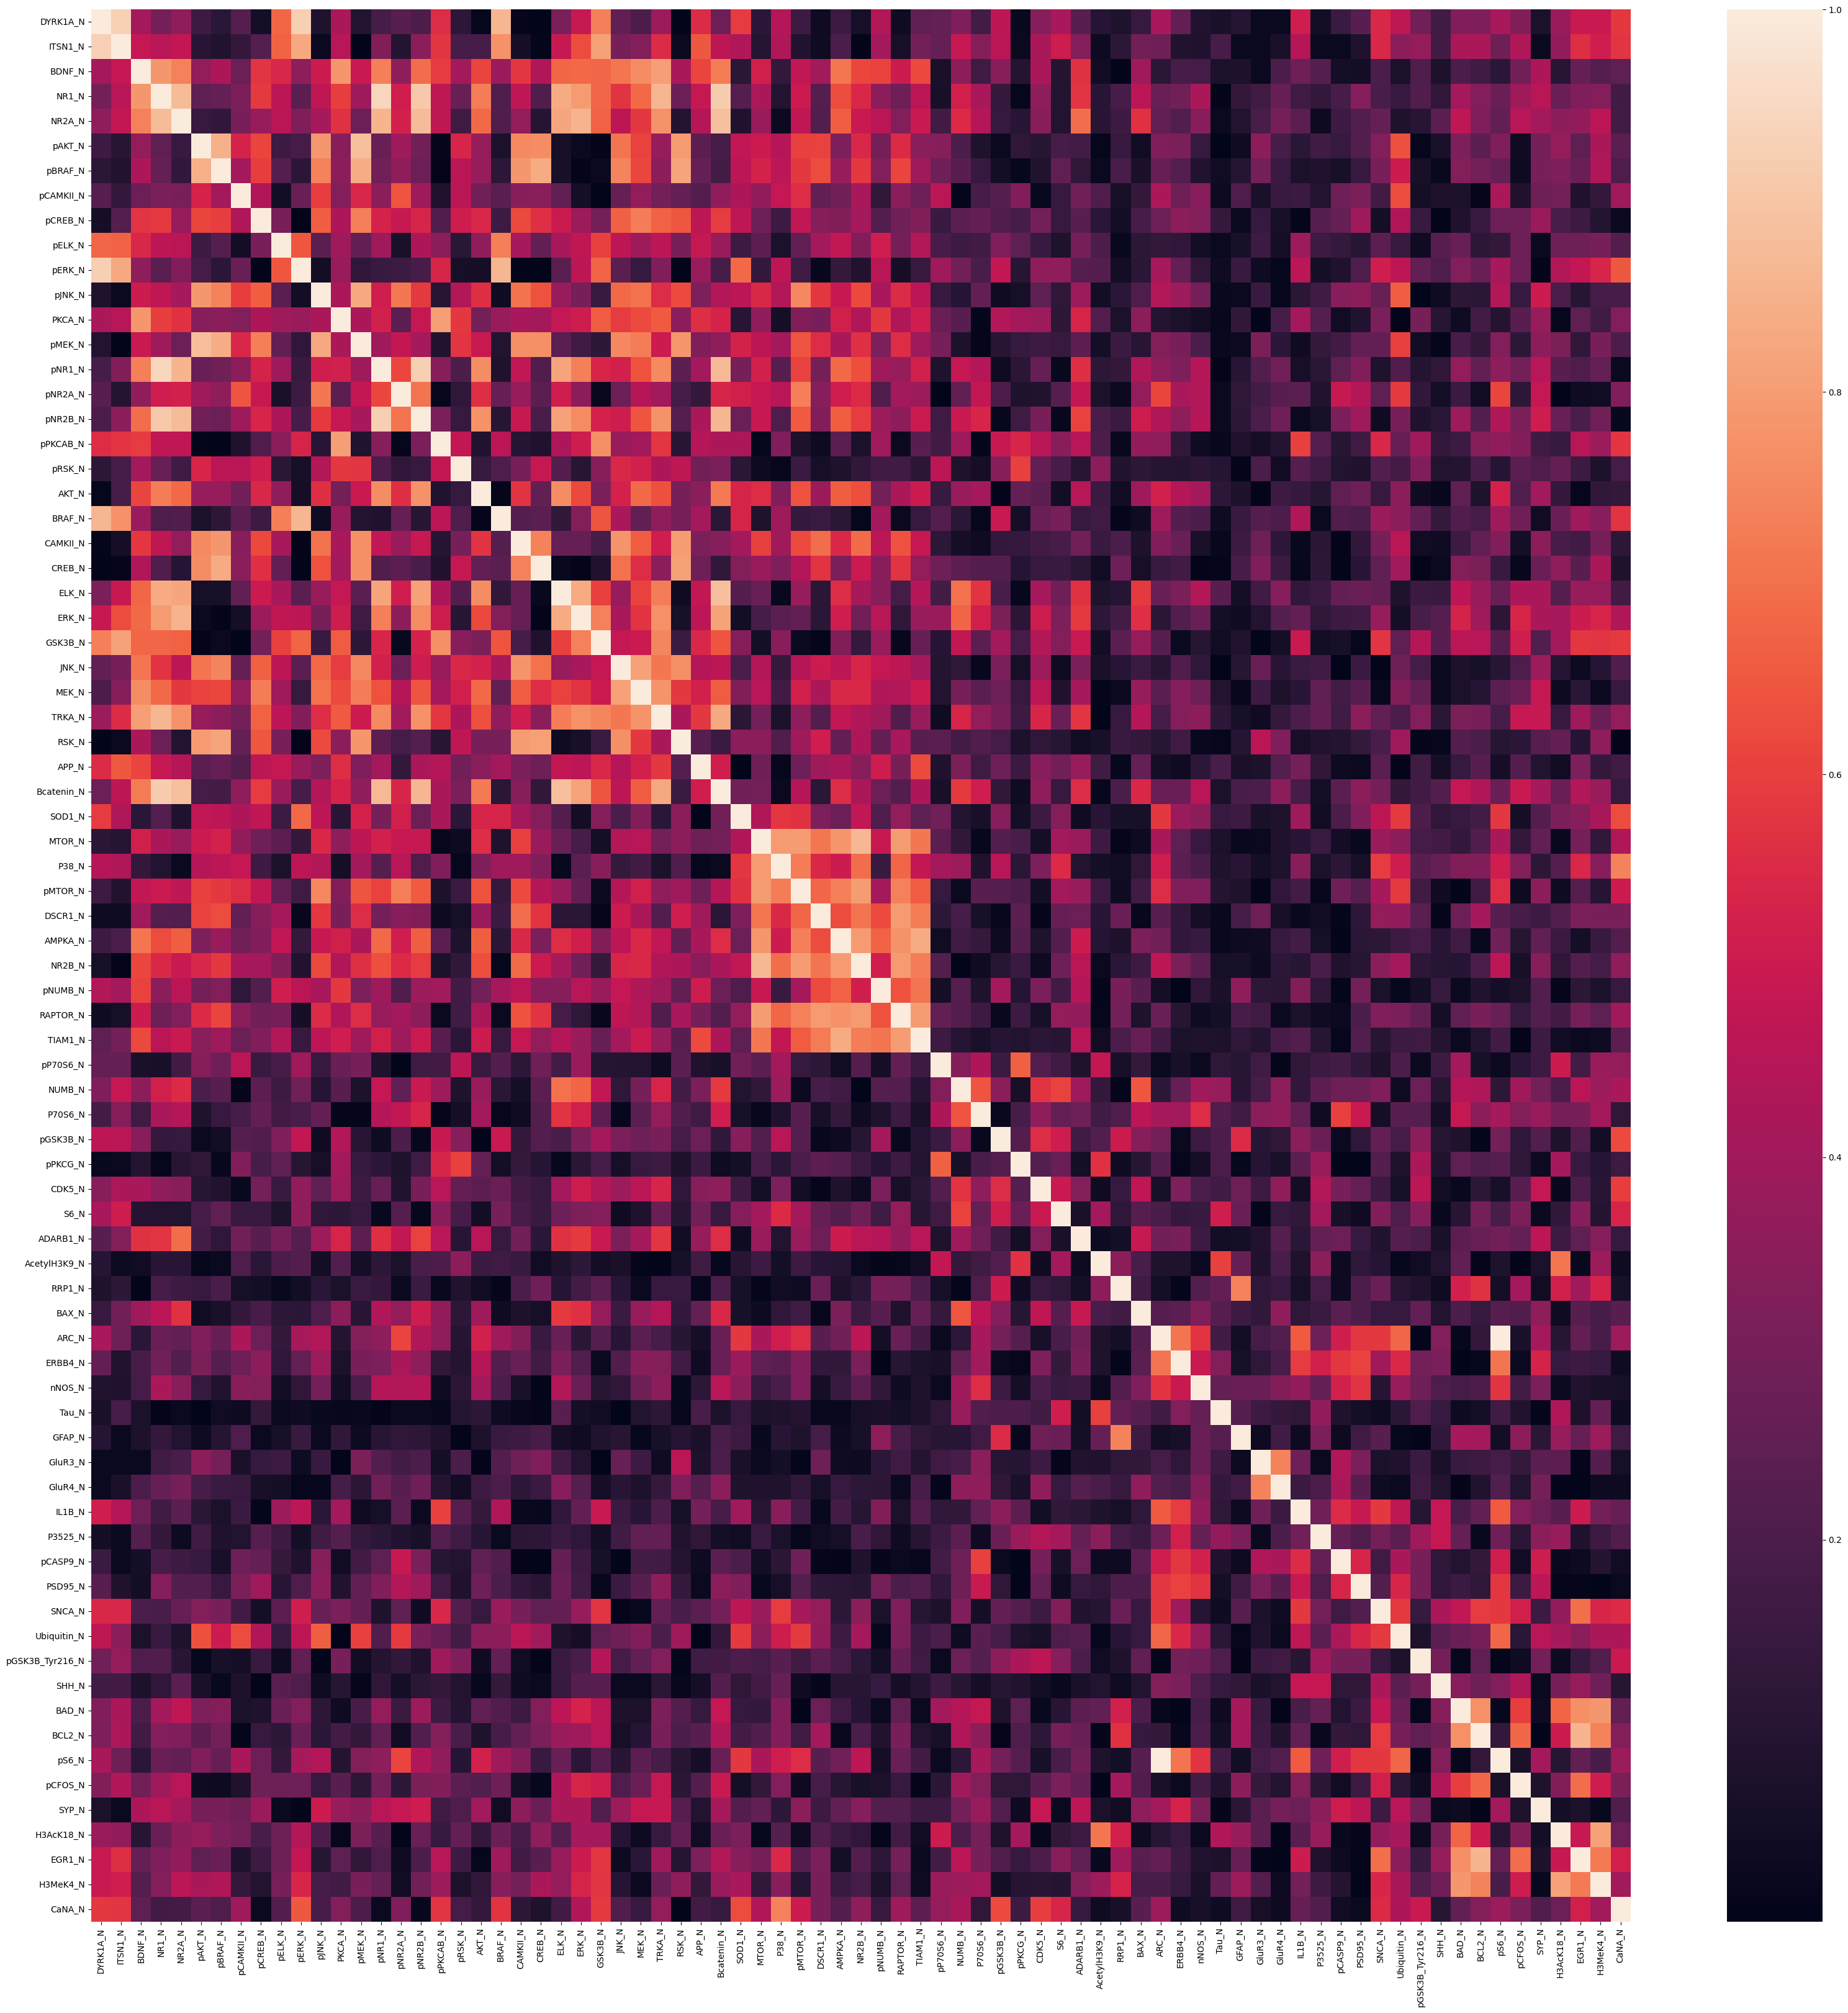

In [25]:
fig, ax = plt.subplots(figsize=(40, 40)) # plotting
corrMatrix = df.corr(method='spearman') # Use spearman for non-linear
sns.heatmap(abs(corrMatrix), annot=False) # Show absolute value

high_corr_vars = set() # keep record
for i in range(len(corrMatrix.columns)):
    for j in range(i):
        if abs(corrMatrix.iloc[i, j]) > 0.8: # if correlated add to set
            high_corr_vars.add(corrMatrix.columns[i])
            high_corr_vars.add(corrMatrix.columns[j])

print(f'Highly correlated features: {high_corr_vars}')
plt.show()

Observations:

36 out of 77 features are highly correlated i.e correlation index more than 0.8 and we can thus eliminate these variables.

## 2.c
c. Train, validate varying at least one hyperparameter, and test at least two types of models: [2]i. Random forest
ii. Support vector classification using RBF kernel
iii. Neural network with single hidden layer (output layer should be have softmax activation)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

X = df.drop('class', axis=1) # get features
y = df['class'] # get target

# Split data into temporary dataset and holdout dataset (60% train, 40% holdout)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=seed)

# Split holdout dataset into validation and test datasets (50% validation, 50% test of pending 40%)
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=seed)

# Imputing Dataset
imp_mean = IterativeImputer(random_state=seed)
X_train = imp_mean.fit_transform(X_train)
X_val = imp_mean.transform(X_val)
X_test = imp_mean.transform(X_test)

# Normalize X_train
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Transform X_val and X_test using the same scaler
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Verify the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (864, 77)
Validation set shape: (108, 77)
Test set shape: (108, 77)


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Define models
models = {
    "Random Forest": RandomForestClassifier(),
    "SVC with RBF kernel": SVC(kernel='rbf'),
    "Neural Network": MLPClassifier(max_iter=100, activation='logistic')
}

# Define hyperparameters to varry and search over
params = {
    "Random Forest": {"n_estimators": [50, 100, 200]},
    "SVC with RBF kernel": {"C": [0.1, 1, 10], "gamma": ['scale', 'auto']},
    "Neural Network": {"hidden_layer_sizes": [(50,), (100,), (200,)], "alpha": [0.0001, 0.001, 0.01]}
}

# Train, validate, and test models
for name, model in models.items():
    print(f"Training and tuning {name}...")

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, params[name], cv=5, scoring='accuracy',)
    grid_search.fit(X_train, y_train)

    # Get best estimator
    best_model = grid_search.best_estimator_
    models[name] = best_model

    # Train
    y_train_pred = best_model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    print(f"Training Accuracy: {train_acc}")

    # Validate
    y_val_pred = best_model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_acc}")

    # Test
    y_test_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_acc}\n")

Training and tuning Random Forest...
Training Accuracy: 1.0
Validation Accuracy: 1.0
Test Accuracy: 0.9907407407407407

Training and tuning SVC with RBF kernel...
Training Accuracy: 1.0
Validation Accuracy: 0.9907407407407407
Test Accuracy: 1.0

Training and tuning Neural Network...
Training Accuracy: 0.9988425925925926
Validation Accuracy: 0.9814814814814815
Test Accuracy: 0.9814814814814815



In [28]:
from sklearn.inspection import permutation_importance
import shap

feature_weights = lambda y: sorted(zip(df.columns, y / sum(y)), key=lambda x: x[1], reverse=True) # sorting based on importance

rf_importances = np.abs(models['Random Forest'].feature_importances_) # using feature_importances_
svr_coefs = np.abs(permutation_importance(models['SVC with RBF kernel'], X_train, y_train, random_state=seed).importances_mean) # using permutation_importance
nn_coefs = np.abs(permutation_importance(models['Neural Network'], X_train, y_train, random_state=seed).importances_mean) # using permutation_importance

print("Random Forest Feature Importances:")
for i, importance in feature_weights(rf_importances):
    print(f"{i}: {importance}")

print("\nSVC Feature Importances:")
for i, importance in feature_weights(svr_coefs):
    print(f"{i}: {importance}")

print("\nNeural Network Feature Importances:")
for i, importance in feature_weights(nn_coefs):
    print(f"{i}: {importance}")

Random Forest Feature Importances:
SOD1_N: 0.056116573997099156
pERK_N: 0.04139073094964579
pPKCG_N: 0.03644553385422463
APP_N: 0.03132395199775226
CaNA_N: 0.03073963111545347
pCAMKII_N: 0.029656294333788354
DYRK1A_N: 0.026949826261459114
ITSN1_N: 0.025837297883315152
Ubiquitin_N: 0.02545811561005635
Tau_N: 0.0244462595037734
pS6_N: 0.02439744676327704
pPKCAB_N: 0.023395991947571786
ARC_N: 0.02315452788986338
BRAF_N: 0.022757983797659594
S6_N: 0.021766185395548594
P38_N: 0.02019307705753081
pP70S6_N: 0.01986884083800932
pNUMB_N: 0.019660005235625843
AcetylH3K9_N: 0.019513272084638537
pGSK3B_N: 0.015991542190654746
nNOS_N: 0.015601375811822173
AKT_N: 0.01384077322984408
pNR2A_N: 0.013828707815282993
ADARB1_N: 0.01308209289602524
pMTOR_N: 0.012529248325027604
MTOR_N: 0.012439353098067265
PKCA_N: 0.01221226538778488
IL1B_N: 0.01188830331756703
RRP1_N: 0.011490628707404128
H3AcK18_N: 0.010848500171236147
NR2B_N: 0.010036053426913135
RAPTOR_N: 0.0097337551684007
pELK_N: 0.009705476106809812

Observations:

alot of features are not important and can be eliminated to reduce models complexity and improves models performances.

## 2.d
d. See if removing some features systematically will improve your models using recursive featureelimination https://scikitlearn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html). [1]

In [31]:
from sklearn.feature_selection import RFECV

model = models['Random Forest']
rfecv = RFECV(estimator=model, step=0.5, scoring='accuracy')
rfecv.fit(X_train, y_train)
print(f"\nOptimal number of features for {name}: {rfecv.n_features_}")
print(f"Selected features for {name}:\n{np.array(X.columns)[rfecv.support_]}")

# Transform training data to selected features
X_train_selected = rfecv.transform(X_train)
model.fit(X_train_selected, y_train)

 # Train
y_train_pred = model.predict(rfecv.transform(X_train))
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc}")

# Validate
y_val_pred = model.predict(rfecv.transform(X_val))
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc}")

# Test
y_test_pred = model.predict(rfecv.transform(X_test))
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc}\n")


Optimal number of features for Neural Network: 39
Selected features for Neural Network:
['DYRK1A_N' 'ITSN1_N' 'pCAMKII_N' 'pELK_N' 'pERK_N' 'PKCA_N' 'pNR2A_N'
 'pPKCAB_N' 'AKT_N' 'BRAF_N' 'CAMKII_N' 'GSK3B_N' 'APP_N' 'SOD1_N'
 'MTOR_N' 'P38_N' 'pMTOR_N' 'AMPKA_N' 'NR2B_N' 'pNUMB_N' 'RAPTOR_N'
 'pP70S6_N' 'NUMB_N' 'pGSK3B_N' 'pPKCG_N' 'S6_N' 'ADARB1_N' 'AcetylH3K9_N'
 'ARC_N' 'ERBB4_N' 'nNOS_N' 'Tau_N' 'IL1B_N' 'P3525_N' 'PSD95_N'
 'Ubiquitin_N' 'pS6_N' 'H3AcK18_N' 'CaNA_N']
Training Accuracy: 1.0
Validation Accuracy: 0.9907407407407407
Test Accuracy: 0.9907407407407407



In [33]:
feature_weights = lambda y: sorted(zip(df.columns, y / sum(y)), key=lambda x: x[1], reverse=True)
rf_importances = np.abs(models['Random Forest'].feature_importances_) # check importance again

print("Random Forest Feature Importances:")
for i, importance in feature_weights(rf_importances):
    print(f"{i}: {importance}")

Random Forest Feature Importances:
pMEK_N: 0.08212212153959973
ERK_N: 0.047776011603964684
PKCA_N: 0.04757598479163606
NR2A_N: 0.04284083753031818
BDNF_N: 0.042069696883322134
NR2B_N: 0.0374141780023254
Bcatenin_N: 0.03500370042851388
ITSN1_N: 0.03240024056258321
DSCR1_N: 0.03158067778615288
pMTOR_N: 0.0314540477787875
DYRK1A_N: 0.030562194086372386
pCAMKII_N: 0.030363970733248993
pELK_N: 0.028831349580349733
TRKA_N: 0.028709296103125784
CAMKII_N: 0.027599393968067654
MEK_N: 0.02759835770249925
GSK3B_N: 0.02662870872392458
ELK_N: 0.026214441946574026
pNR2A_N: 0.024775169891356662
AKT_N: 0.023163617412683277
APP_N: 0.01894148615605716
pCREB_N: 0.018846089302697572
JNK_N: 0.018201055771587794
SOD1_N: 0.01789318448414129
pAKT_N: 0.017580638443049416
pBRAF_N: 0.017373183160609526
BRAF_N: 0.016302377695740163
pNR2B_N: 0.01605720693285432
pNR1_N: 0.01588994621201425
AMPKA_N: 0.015670988970013282
P38_N: 0.01533246837572016
RSK_N: 0.014670569876555817
pERK_N: 0.014495181698939732
CREB_N: 0.014

Observations:

Even after reducing size of the input features from 77 to 39, i.e reducing to 50%, my models accuracy is still the same, indicating that those features were redundunt. Complexity of models is reducing by 50% while maintaining the same accuracy scores.

# Part 3 - Pre-trained neural networks

## 3.a
a. Read the pytorch tutorial to use a pre-trained “ConvNet as fixed feature extractor” fromhttps://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html and you can ignore
“finetuning the ConvNet”. Test this code out to see if it runs properly in your environment aftereliminating code blocks that you do not need. [1]

In [36]:
# importing libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True

In [37]:
# Downloadina and extracting dataset
! rm -rf hymenoptera_data
! wget -q https://download.pytorch.org/tutorial/hymenoptera_data.zip
! unzip -q hymenoptera_data.zip
! rm -rf hymenoptera_data.zip

In [38]:
# Setting up train and val transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# USing code from gicen documentation
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

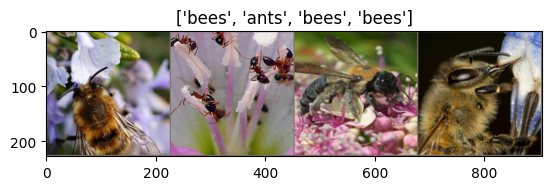

In [39]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [40]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


In [41]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

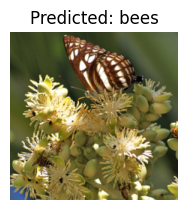

In [42]:
visualize_model_predictions(
    model_conv,
    img_path='hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

The following transfer learning code is working fine for me

## 3.b
b. Write a function that outputs ResNet18 features for a given input image. Extract features for trainingimages (in image_datasets['train']). You should get an Nx512 dimensional array. [1]

In [43]:
# importing libraries
from torchvision import transforms, datasets
import torch
import os

# Setting transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Setting device and data_loaders

In [44]:
from torchvision import models

# Load pre-trained ResNet18 model
resnet_model = models.resnet18(weights='IMAGENET1K_V1')

# Set model to evaluation mode
resnet_model.eval()

# Extract ResNet18 features for training images
X_train, y_train, X_test, y_test = [], [], [], []

for inputs, labels in dataloaders['train']:
    inputs = inputs.to(device)
    features = resnet_model(inputs)
    X_train.append(features)
    y_train.append(labels)

# Concatenate features and labels
X_train = torch.cat(X_train, dim=0).detach().numpy()
y_train = torch.cat(y_train, dim=0).numpy()

for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    features = resnet_model(inputs)
    X_test.append(features)
    y_test.append(labels)

# Concatenate features and labels
X_test = torch.cat(X_test, dim=0).detach().numpy()
y_test = torch.cat(y_test, dim=0).numpy()

X_train = X_train[:,:512] # picking only 1st important 512 features
X_test = X_test[:,:512] # picking only 1st important 512 features

# Check the dimensions of the extracted features
print("Dimensions of train extracted features:", X_train.shape)
print("Dimensions of test extracted features:", X_test.shape)

Dimensions of train extracted features: (244, 512)
Dimensions of test extracted features: (153, 512)


Choosed only top 512 features for further processing

## 3.c
c. Compare RBF kernel SVM (do grid search on kernel width and regularization) and random forest (dogrid search on max depth and number of trees). Test the final model on test data and show theresults -- accuracy and F1 score. [1]

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Define parameter grids for grid search
svm_param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
rf_param_grid = {'max_depth': [None, 10, 20], 'n_estimators': [50, 100, 200]}

# Perform grid search for SVM
svm_grid_search = GridSearchCV(SVC(kernel='rbf'), svm_param_grid, cv=5)
svm_grid_search.fit(X_train, y_train)

# Perform grid search for Random Forest
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)

# Get best hyperparameters for SVM and Random Forest
best_svm_params = svm_grid_search.best_params_
best_rf_params = rf_grid_search.best_params_

# Train SVM and Random Forest models with best hyperparameters
best_svm_model = SVC(kernel='rbf', **best_svm_params)
best_rf_model = RandomForestClassifier(**best_rf_params)

best_svm_model.fit(X_train, y_train)
best_rf_model.fit(X_train, y_train)

# Predictions on test data
svm_test_preds = best_svm_model.predict(X_test)
rf_test_preds = best_rf_model.predict(X_test)

# Calculate accuracy and F1 score for SVM and Random Forest
svm_accuracy = accuracy_score(y_test, svm_test_preds)
rf_accuracy = accuracy_score(y_test, rf_test_preds)

svm_f1_score = f1_score(y_test, svm_test_preds)
rf_f1_score = f1_score(y_test, rf_test_preds)

print("SVM Accuracy:", svm_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

print("SVM F1 Score:", svm_f1_score)
print("Random Forest F1 Score:", rf_f1_score)

SVM Accuracy: 0.45751633986928103
Random Forest Accuracy: 0.9673202614379085
SVM F1 Score: 0.0
Random Forest F1 Score: 0.9696969696969697


Observations:

Random forest classifier works the best with accuracy of 0.93 with good f1 score.

SVM didnt learn much clearly seen by its f1 score and accuracy.

# Part 4 - Deployment

## 4.a
4. Deploy one model from part 1 on a local webserver with a web frontend (e.g. using streamlit). Add some GUIelements, such as sliders for acidity, citrus etc. [2] Most of this should be in the video demo.

In [128]:
from warnings import filterwarnings as fw
import streamlit as st
import pickle
import random
fw('ignore')

def main():
    # Title of the web app
    st.title('White Wine Quality Predictor')

    # Load data
    white_wine_data = pickle.load(open('white_wine_data.pkl', 'rb'))
    df = white_wine_data['df']
    scaler = white_wine_data['scaler']
    model = white_wine_data['model']

    # Session state to store slider values
    slider_dict = st.session_state.slider if 'slider' in st.session_state else {}

    # Description
    st.write('Enter the characteristics of the wine to predict its quality.')

    # Function to create sliders
    def get_sliders(rand=False):
        random_row = df.sample()
        for column in df.columns[:-1]:
            min_val = df[column].min()
            max_val = df[column].max()
            step = round((max_val - min_val) / 100, 3)
            try:
                if rand or 'slider' not in st.session_state:
                    # Create slider with random value
                    slider_dict[column] = st.slider(column, min_value=min_val, max_value=max_val, step=step, value=random_row[column].values[0])
                else:
                    # Use previous value if available
                    slider_dict[column] = st.slider(column, min_value=min_val, max_value=max_val, step=step, value=slider_dict[column])
            except: pass

    # Generate sliders if Random button is clicked or for initial load
    if st.button('Random') or 'init' not in st.session_state:
        st.session_state.init = False
        get_sliders(True)
        st.session_state.slider = slider_dict

    # Display sliders
    get_sliders(False)

    # Prediction button
    if st.button('Predict'):
        # Transform features and make prediction
        features = [list(slider_dict.values())]
        features = scaler.transform(features)
        quality = model.predict(features)[0]
        # Display predicted quality with success message
        st.success(f'The predicted wine quality is {quality}')

Conclusions:

Completed all Parts 1-4 successfully.